# MAP-Elites using pyribs

In [1]:
import numpy as np
import requests
from ribs.archives import GridArchive
from ribs.emitters import EvolutionStrategyEmitter
from ribs.schedulers import Scheduler
from ribs.visualize import grid_archive_heatmap
import matplotlib.pyplot as plt

In [4]:
# Server JS which exposes the trackGenerations and genetic operators 
SERVER_URL = 'http://localhost:4242'

## Genetic operators

In [9]:
def calculate_fitness(fitness_data):
    length = fitness_data['length']
    error = np.sqrt(fitness_data['deltaX']**2 + fitness_data['deltaY']**2)
    return length - 10 * error

def evaluate_track(track, mode):
    try:
        data = {'mode': mode}
        if track is not None:
            data['track'] = track.tolist()
        response = requests.post(f'{SERVER_URL}/evaluate', json=data)
        response.raise_for_status()
        result = response.json()
        fitness_data = result['fitness']
        # Combined fitness metrics into a single value: a weighted sum as test
        fitness = -(fitness_data['length'] + 10*fitness_data['deltaX'] + 10*fitness_data['deltaY'] + fitness_data['deltaAngleDegrees'])
        return fitness, np.array(result['track'])
    except requests.RequestException as e:
        print(f"Error evaluating track: {e}")
        return float('-inf'), None

def crossover(parent1, parent2, mode):
    try:
        response = requests.post(f'{SERVER_URL}/crossover', 
                                 json={'parent1': parent1.tolist(), 'parent2': parent2.tolist(), 'mode': mode})
        response.raise_for_status()
        return np.array(response.json()['offspring'])
    except requests.RequestException as e:
        print(f"Error performing crossover: {e}")
        return parent1

def mutate(individual, mode):
    try:
        response = requests.post(f'{SERVER_URL}/mutate', 
                                 json={'individual': individual.tolist(), 'mode': mode})
        response.raise_for_status()
        return np.array(response.json()['mutated'])
    except requests.RequestException as e:
        print(f"Error performing mutation: {e}")
        return individual

## Illuminating search spaces by mapping elites

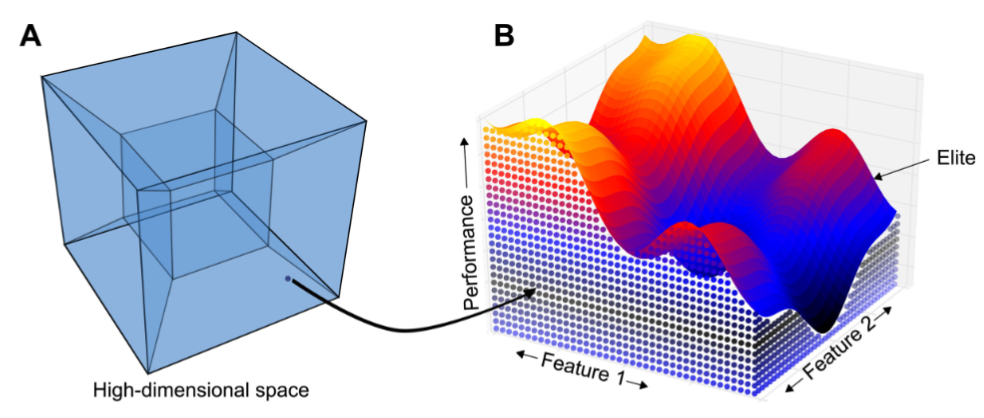

In [10]:
def run_map_elites(iterations, solution_dim=50, archive_dims=[20, 20], mode='voronoi', initial_population_size=100):
    archive = GridArchive(solution_dim=50,  # Adjust based on your solution dimension
                      dims=[20, 20],  # 20x20 grid, adjust as needed
                      ranges=[(-1, 1), (-1, 1)])  # Adjust ranges for your measures

    emitters = [EvolutionStrategyEmitter(archive,
                                        x0=np.zeros(50),  # Initial solution
                                        sigma0=0.1,
                                        batch_size=36) for _ in range(5)]  # 5 emitters

    scheduler = Scheduler(archive, emitters)
        
    # Generate initial population
    population = []
    for _ in range(initial_population_size):
        fitness, track = evaluate_track(None, mode)
        if track is not None:
            population.append(track)
            measure = track[:2]  # Assuming first two elements are the measure
            archive.add(track, measure, fitness)
    
    for itr in range(1000):  # 1000 iterations
    solutions = scheduler.ask()
    
    objectives = []
    measures = []
    for solution in solutions:
        track = generate_track(solution)  # Your track generation function
        fitness_data = evaluate_track(track)  # Your evaluation function
        fitness = calculate_fitness(fitness_data)
        measure = calculate_measures(track)
        
        objectives.append(fitness)
        measures.append(measure)
    
    scheduler.tell(objectives, measures)


iterations = 1000
mode = 'voronoi'  # or 'convexHull'
archive = run_map_elites(iterations, mode=mode)

Error evaluating track: HTTPConnectionPool(host='localhost', port=4242): Max retries exceeded with url: /evaluate (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000024005090E10>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))


KeyboardInterrupt: 

## Visualize Results

In [ ]:
plt.figure(figsize=(8, 6))
grid_archive_heatmap(archive)
plt.title(f"MAP-Elites Archive after {iterations} iterations")
plt.show()

## Archive Statistics

In [ ]:
print(f"Archive coverage: {archive.stats.coverage}")
print(f"Maximum objective: {archive.stats.obj_max}")
print(f"Average objective: {archive.stats.obj_mean}")